In [161]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
#set_nb_theme('onedork')

In [162]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import stats
print("Setup Complete")

Setup Complete


# This project will be looking at data from the US census bureau and training a classification model to predict whether someone makes more or less than 50,000 a year

## Read data

In [227]:
path = 'adult.data.csv'
data = pd.read_csv(path)

# when reading the data in at first on of the rows is made into the columns so we need to fix that
col_dict = {'39': 'Age',
            ' State-gov': 'workclass',
            ' 77516': 'fnlwgt',
            ' Bachelors': 'education',
            ' 13':'education-num',
            ' Never-married': 'marital-status',
            ' Adm-clerical': 'occupation',
            ' Not-in-family': 'relationship',
            ' White': 'race',
            ' Male': 'sex',
            ' 2174': 'capital-gain',
            ' 0': 'capital-loss',
            ' 40': 'hours-per-week',
            ' United-States': 'native-country',
            ' <=50K': 'income'}
data = data.rename(columns=col_dict)

In [228]:
#make target variable quantitative instead of categorical
data['income'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)

# Getting some preliminary info about the data

In [229]:
data.head()

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [230]:
data.describe()

,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469,0.240817
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618,0.427586
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [231]:
# making sure each column with some unknown data has different labels for unknowns
data['workclass'] = data['workclass'].replace(' ?', value='unknown')
data['native-country'] = data['native-country'].replace(' ?', value='mystery')

## The test data has some formatting problems we are going to fix here to make it match the training data

In [232]:
test_path = 'adult.test.csv'
test = pd.read_csv(test_path)

In [233]:
columns = ['Age',
           'workclass',
           'fnlwgt',
           'education',
           'education-num',
           'marital-status',
           'occupation',
           'relationship',
           'race',
           'sex',
           'capital-gain',
           'capital-loss',
           'hours-per-week',
           'native-country',
           'income']

In [234]:
import warnings
warnings.filterwarnings("ignore") #since we get a bunch of warnings for using append
test_df = pd.DataFrame()
for i in range(0,len(test)):
    idx_lst = list(test.index[i])
    idx_lst.append(test.iloc[i]['|1x3 Cross validator'])
    row = dict(zip(columns, idx_lst))
    test_df = test_df.append(row, ignore_index=True)
        
test_df['income'].replace({' <=50K.': '0', ' >50K.': 1}, inplace=True)

In [235]:
test_df['native-country'] = test_df['native-country'].replace(' ?', value='mystery')
test_df['workclass'] = test_df['workclass'].replace(' ?', value='unknown')

<AxesSubplot: xlabel='Age', ylabel='Count'>

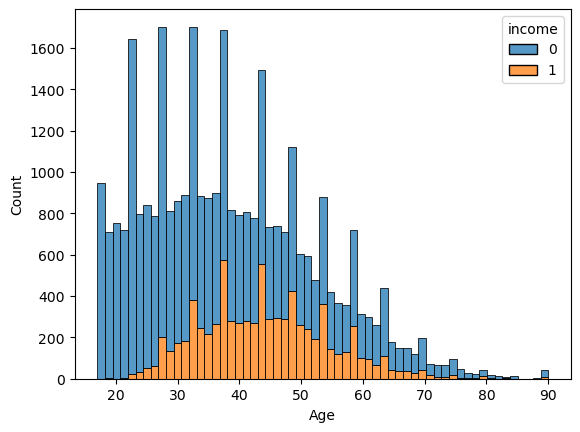

In [236]:
# doing some visualization between age and income
sns.histplot(data=data, x='Age', hue='income', multiple='stack')

<AxesSubplot: xlabel='fnlwgt', ylabel='Count'>

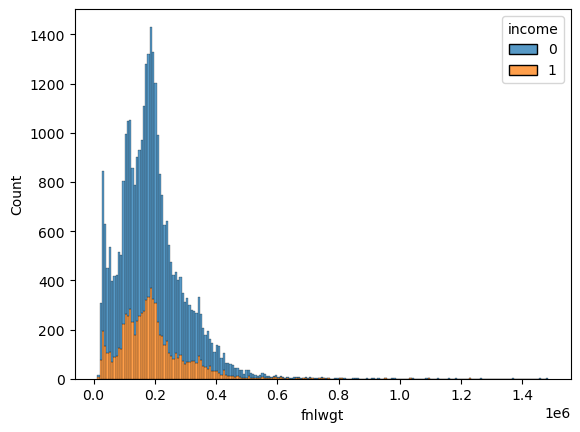

In [237]:
# doing some visualization between age and income
sns.histplot(data=data, x='fnlwgt', hue='income', multiple='stack')

# fnlwgt does not seem to influence income a lot so we will most likely drop this later

In [238]:
# we will make a function to add a second column to the value_counts() dataframe with the perentage of each category 
# earning over 50,000 a year
def fetch_percent(df, column):
    temp = df[column].value_counts()
    temp = pd.DataFrame(temp)
    values = list(temp.index)
    l = []
    for value in values:
        value_df = df[df[column] == value]
        percentage = round(sum(list(df[df[column] == value]['income']))/len(data[data[column] == value]), 3) * 100
        l.append(percentage)
    temp['Percent over 50k'] = l
    return temp

# Now we will start trying to simplify the data by lowering the amount of values certain categorical values can take. We'll start with countries

In [239]:
print(fetch_percent(data, 'native-country'))

                             native-country  Percent over 50k
 United-States                        29169              24.6
 Mexico                                 643               5.1
mystery                                 583              25.0
 Philippines                            198              30.8
 Germany                                137              32.1
 Canada                                 121              32.2
 Puerto-Rico                            114              10.5
 El-Salvador                            106               8.5
 India                                  100              40.0
 Cuba                                    95              26.3
 England                                 90              33.3
 Jamaica                                 81              12.3
 South                                   80              20.0
 China                                   75              26.7
 Italy                                   73              34.2
 Dominic

In [240]:
country_df = fetch_percent(data, 'native-country')
data = data.replace(' United-States', value='United-States')
wealthy_countries = list(country_df[country_df['Percent over 50k'].between(24,100)].index)
wealthy_countries.remove(' United-States')
middle_countries = list(country_df[country_df['Percent over 50k'].between(12,24)].index)
poor_countries = list(country_df[country_df['Percent over 50k'].between(0,12)].index)

In [241]:
def df_replace(df, lst, replace_value=None):
    if replace_value is None:
        return None
    for item in lst:
        df = df.replace(item, value=replace_value)
    return df
    

In [242]:
data = df_replace(data, wealthy_countries, replace_value='Foreign-wealthy')
data = df_replace(data, middle_countries, replace_value='Foreign-middle')
data = df_replace(data, poor_countries, replace_value='Foreign-poor')
print(fetch_percent(data, 'native-country'))

                 native-country  Percent over 50k
United-States             29169              24.6
Foreign-wealthy            1753              30.5
Foreign-poor               1334               6.2
Foreign-middle              304              17.4


# We'll use get_dummies to one hot encode everything after we're done

# Now onto occupations

In [243]:
print(fetch_percent(data, 'occupation'))
job_df = fetch_percent(data, 'occupation')
wealthy_jobs = list(job_df[job_df['Percent over 50k'].between(24,100)].index)
middle_jobs = list(job_df[job_df['Percent over 50k'].between(12,24)].index)
poor_jobs = list(job_df[job_df['Percent over 50k'].between(0,12)].index)


                    occupation  Percent over 50k
 Prof-specialty           4140              44.9
 Craft-repair             4099              22.7
 Exec-managerial          4066              48.4
 Adm-clerical             3769              13.5
 Sales                    3650              26.9
 Other-service            3295               4.2
 Machine-op-inspct        2002              12.5
 ?                        1843              10.4
 Transport-moving         1597              20.0
 Handlers-cleaners        1370               6.3
 Farming-fishing           994              11.6
 Tech-support              928              30.5
 Protective-serv           649              32.5
 Priv-house-serv           149               0.7
 Armed-Forces                9              11.1


In [244]:
data = df_replace(data, wealthy_jobs, replace_value='good-occupation')
data = df_replace(data, middle_jobs, replace_value='ok-occupation')
data = df_replace(data, poor_jobs, replace_value='bad-occupation')
print(fetch_percent(data, 'occupation'))

                 occupation  Percent over 50k
good-occupation       13433              39.5
ok-occupation         11467              17.5
bad-occupation         7660               6.9


# Now marital status

In [245]:
print(fetch_percent(data, 'marital-status'))
Married = [' Married-civ-spouse', ' Married-AF-spouse']
Not_married = [' Never-married', ' Divorced', ' Separated', ' Widowed', ' Married-spouse-absent']


                        marital-status  Percent over 50k
 Married-civ-spouse              14976              44.7
 Never-married                   10682               4.6
 Divorced                         4443              10.4
 Separated                        1025               6.4
 Widowed                           993               8.6
 Married-spouse-absent             418               8.1
 Married-AF-spouse                  23              43.5


In [246]:
data = df_replace(data, Married, replace_value='Married')
data = df_replace(data, Not_married, replace_value='Not Married')
print(fetch_percent(data, 'marital-status'))

             marital-status  Percent over 50k
Not Married           17561               6.5
Married               14999              44.7


In [247]:
print(fetch_percent(data, 'marital-status'))

             marital-status  Percent over 50k
Not Married           17561               6.5
Married               14999              44.7


# Relationship should be similar


In [248]:
print(fetch_percent(data, 'relationship'))
married = [' Husband', ' Wife']
not_married = [' Not-in-family', ' Own-child', ' Unmarried', ' Other-relative']


                 relationship  Percent over 50k
 Husband                13193              44.9
 Not-in-family           8304              10.3
 Own-child               5068               1.3
 Unmarried               3446               6.3
 Wife                    1568              47.5
 Other-relative           981               3.8


In [249]:
data = df_replace(data, married, replace_value='Married')
data = df_replace(data, not_married, replace_value='Not Married')
print(fetch_percent(data, 'relationship'))

             relationship  Percent over 50k
Not Married         17799               6.6
Married             14761              45.1


# Based on this we will most likely end up just removing the relationship column

In [250]:
print(fetch_percent(data, 'education'))
highly_educated = [' Doctorate', ' Prof-school', ' Masters']
bachelors = [' Bachelors']
assoc = [' Assoc-voc', ' Assoc-acdm']
lt_assoc = [' HS-grad', ' Some-college', ' 11th', ' 10th', ' 7th-8th', ' 9th', ' 12th', ' 5th-6th', ' 1st-4th', ' Preschool']

               education  Percent over 50k
 HS-grad           10501              16.0
 Some-college       7291              19.0
 Bachelors          5354              41.5
 Masters            1723              55.7
 Assoc-voc          1382              26.1
 11th               1175               5.1
 Assoc-acdm         1067              24.8
 10th                933               6.6
 7th-8th             646               6.2
 Prof-school         576              73.4
 9th                 514               5.3
 12th                433               7.6
 Doctorate           413              74.1
 5th-6th             333               4.8
 1st-4th             168               3.6
 Preschool            51               0.0


In [251]:
data = df_replace(data, highly_educated, replace_value='highly-educated')
data = df_replace(data, bachelors, replace_value='bachelors')
data = df_replace(data, assoc, replace_value='associates')
data = df_replace(data, lt_assoc, replace_value='no-college')
print(fetch_percent(data, 'education'))


                 education  Percent over 50k
no-college           22045              15.0
bachelors             5354              41.5
highly-educated       2712              62.2
associates            2449              25.6


In [252]:
print(fetch_percent(data, 'race'))
white_asian = [' White', ' Asian-Pac-Islander']
other = [' Black', ' Amer-Indian-Eskimo', ' Other']

                      race  Percent over 50k
 White               27815              25.6
 Black                3124              12.4
 Asian-Pac-Islander   1039              26.6
 Amer-Indian-Eskimo    311              11.6
 Other                 271               9.2


In [253]:
data = df_replace(data, white_asian, replace_value='White-asian')
data = df_replace(data, other, replace_value='other')
print(fetch_percent(data, 'race'))

              race  Percent over 50k
White-asian  28854              25.6
other         3706              12.1


In [254]:
print(fetch_percent(data, 'workclass'))
good_workclass = [' Self-emp-inc', ' Federal-gov']
middle_workclass = [' Local-gov', ' Self-emp-not-inc', ' Private', ' State-gov']
unknown = ['unknown']
no_workclass = [' Without-pay', ' Never-worked']

                   workclass  Percent over 50k
 Private               22696              21.9
 Self-emp-not-inc       2541              28.5
 Local-gov              2093              29.5
unknown                 1836              10.4
 State-gov              1297              27.2
 Self-emp-inc           1116              55.7
 Federal-gov             960              38.6
 Without-pay              14               0.0
 Never-worked              7               0.0


In [255]:
data = df_replace(data,good_workclass, replace_value='good-workclass')
data = df_replace(data, middle_workclass, replace_value='middle-workclass')
data = df_replace(data, no_workclass, replace_value='neet')
print(fetch_percent(data, 'workclass'))


                  workclass  Percent over 50k
middle-workclass      28627              23.3
good-workclass         2076              47.8
unknown                1836              10.4
neet                     21               0.0


# We are now done transforming the categorical variables. We will now import the machine learning libraries we will use and do some normalization

In [256]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras import Sequential
from keras.layers import LeakyReLU, Dense
from keras import losses
from tensorflow.keras.callbacks import EarlyStopping

In [257]:
# We will drop fnlwgt for now as it doesn't seem to be indicative of income
# we might add education-num later, we will have to do some experiments
cols_to_drop = ['fnlwgt', 'relationship']
data = data.drop(cols_to_drop, axis=1)

# First we will try ordinal encoding workclass, education, and occupation. It might work or might not. We will come back later try not doing this

In [258]:
workclass_dict = {'neet': 0, 'unknown': 1, 'middle-workclass': 2, 'good-workclass': 3}
education_dict = {'no-college': 0, 'associates':1,  'bachelors': 2, 'highly-educated': 3} 
occupation_dict = {'bad-occupation': 0, 'ok-occupation': 1, 'good-occupation': 2}

In [259]:
data['workclass'] = data['workclass'].map(workclass_dict)
data['education'] = data['education'].map(education_dict)
data['occupation'] = data['occupation'].map(occupation_dict)

# We'll try minmax scaling first. we'll scale age, education num, capital gain, capital loss and hours per week

In [260]:
cols_to_scale = ['Age','workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
data[cols_to_scale] = minmax_scaler.fit_transform(data[cols_to_scale])

# Since marital-status, race, and sex only have 2 values we can just use replace and have it be 0,1

In [261]:
data['marital-status'].replace({'Not Married': 0, 'Married': 1}, inplace=True)
data['race'].replace({'other': 0, 'White-asian': 1}, inplace=True)
data['sex'].replace({' Female': 0, ' Male': 1}, inplace=True)

In [262]:
# One hot encoding for native country
data = pd.get_dummies(data, columns=['native-country'])

In [263]:
# make column names shorter
col_dict = {'native-country_Foreign-middle': 'Foreign-middle', 'native-country_Foreign-poor': 'Foreign-poor', 'native-country_Foreign-wealthy': 'Foreign-wealthy', 'native-country_United-States': 'United-States'}
data = data.rename(columns=col_dict)

In [264]:
# make sure income is the last column again
cols = list(data.columns)
cols.remove('income')
cols.append('income')
data = data[cols]


# ok now we have to do all that transformation to the test data

In [265]:
test = test_df


In [266]:
test

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,unknown,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
16277,64,unknown,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,0
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [267]:
test = df_replace(test, wealthy_countries, replace_value='Foreign-wealthy')
test = df_replace(test, middle_countries, replace_value='Foreign-middle')
test = df_replace(test, poor_countries, replace_value='Foreign-poor')

test = df_replace(test, married, replace_value='Married')
test = df_replace(test, not_married, replace_value='Not Married')

test = df_replace(test, Married, replace_value='Married')
test = df_replace(test, Not_married, replace_value='Not Married')

test = df_replace(test, good_workclass, replace_value='good-workclass')
test = df_replace(test, middle_workclass, replace_value='middle-workclass')
test = df_replace(test, no_workclass, replace_value='neet')

test = df_replace(test, highly_educated, replace_value='highly-educated')
test = df_replace(test, bachelors, replace_value='bachelors')
test = df_replace(test, assoc, replace_value='associates')
test = df_replace(test, lt_assoc, replace_value='no-college')

test = df_replace(test, wealthy_jobs, replace_value='good-occupation')
test = df_replace(test, middle_jobs, replace_value='ok-occupation')
test = df_replace(test, poor_jobs, replace_value='bad-occupation')


test = df_replace(test, white_asian, replace_value='White-asian')
test = df_replace(test, other, replace_value='other')



test['marital-status'].replace({'Not Married': 0, 'Married': 1}, inplace=True)
test['race'].replace({'other': 0, 'White-asian': 1}, inplace=True)
test['sex'].replace({' Female': 0, ' Male': 1}, inplace=True)


workclass_dict = {'neet': 0, 'unknown': 1, 'middle-workclass': 2, 'good-workclass': 3}
education_dict = {'no-college': 0, 'associates':1,  'bachelors': 2, 'highly-educated': 3} 
occupation_dict = {'bad-occupation': 0, 'ok-occupation': 1, 'good-occupation': 2}




test['workclass'] = test['workclass'].map(workclass_dict)
test['education'] = test['education'].map(education_dict)
test['occupation'] = test['occupation'].map(occupation_dict)


test[cols_to_scale] = minmax_scaler.transform(test[cols_to_scale])

cols_to_drop = ['fnlwgt', 'relationship']
test = test.drop(cols_to_drop, axis=1)

In [268]:
test = pd.get_dummies(test, columns=['native-country'])

col_dict = {'native-country_Foreign-middle': 'Foreign-middle', 'native-country_Foreign-poor': 'Foreign-poor', 'native-country_Foreign-wealthy': 'Foreign-wealthy', 'native-country_ United-States': 'United-States'}
test = test.rename(columns=col_dict)

cols = list(test.columns)
cols.remove('income')
cols.append('income')
test = test[cols]

In [269]:
col_dict = {'native-country_Foreign-middle': 'Foreign-middle', 'native-country_Foreign-poor': 'Foreign-poor', 'native-country_Foreign-wealthy': 'Foreign-wealthy', 'native-country_ United-States': 'United-States'}
test = test.rename(columns=col_dict)

In [270]:
y = data.pop('income')

In [271]:
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(max_leaf_nodes=500,random_state=0)
X = data
clf.fit(X, y)

RandomForestClassifier(max_leaf_nodes=500, random_state=0)

In [272]:
y_true = test.pop('income')

In [273]:
y_pred = clf.predict(test)
y_true = np.asarray(y_true, dtype=int)

In [274]:
accuracy_score(y_true, y_pred)

0.8544315459738345

# Final accuracy score of model is 85.4%. Now we will compare this to a tensorflow model

In [275]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [276]:
X.shape[1]

15

In [277]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

In [278]:
model = keras.Sequential()
model.add(Dense(units=128, input_dim=X.shape[1], activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [279]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[early_stopping]) 

Epoch 1/30
814/814 [==============================] - 4s 5ms/step - loss: 0.3908 - accuracy: 0.8212 - val_loss: 0.3546 - val_accuracy: 0.8311
Epoch 2/30
814/814 [==============================] - 3s 3ms/step - loss: 0.3417 - accuracy: 0.8400 - val_loss: 0.3407 - val_accuracy: 0.8385
Epoch 3/30
814/814 [==============================] - 3s 4ms/step - loss: 0.3314 - accuracy: 0.8455 - val_loss: 0.3336 - val_accuracy: 0.8455
Epoch 4/30
814/814 [==============================] - 3s 4ms/step - loss: 0.3259 - accuracy: 0.8470 - val_loss: 0.3290 - val_accuracy: 0.8484
Epoch 5/30
814/814 [==============================] - 3s 4ms/step - loss: 0.3220 - accuracy: 0.8504 - val_loss: 0.3251 - val_accuracy: 0.8486
Epoch 6/30
814/814 [==============================] - 3s 3ms/step - loss: 0.3205 - accuracy: 0.8491 - val_loss: 0.3240 - val_accuracy: 0.8503
Epoch 7/30
814/814 [==============================] - 3s 4ms/step - loss: 0.3186 - accuracy: 0.8519 - val_loss: 0.3219 - val_accuracy: 0.8486
Epoch 

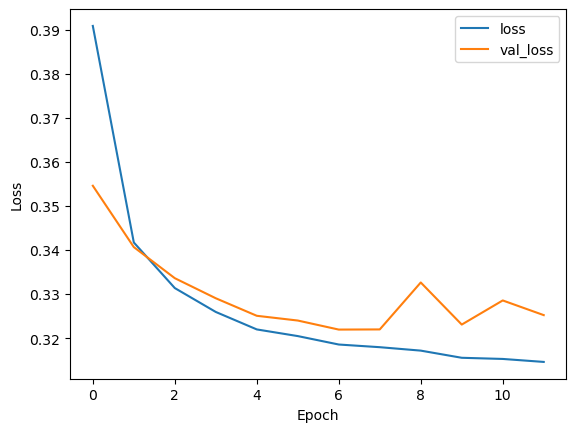

In [280]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

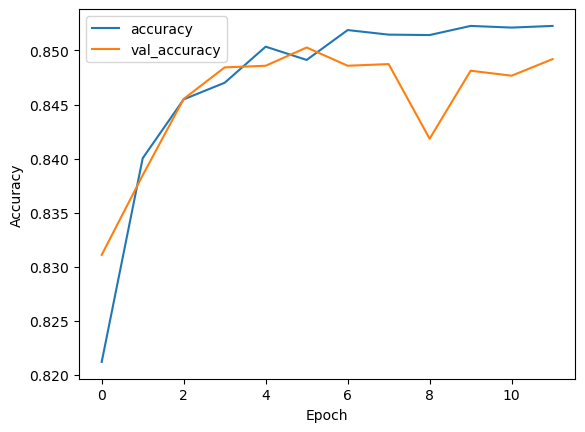

In [281]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [282]:
model.evaluate(test,y_true)

509/509 [==============================] - 2s 3ms/step - loss: 0.3325 - accuracy: 0.8415


[0.3324643075466156, 0.8414784073829651]

# Tensorflow model achieves an 84.2% accuracy score on the test data, around 1% lower than the random forest model